# 006: Running ablations

In [1]:
import json
from dataclasses import asdict
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")
from preprocessing import preprocess
from metrics import f_score
from models import OrdinaryLeastSquares, LogisticRegression, test_val_split
from model_selection import cross_validation

%load_ext autoreload
%autoreload 2

In [2]:
ABLATION_MODEL = OrdinaryLeastSquares

In [2]:
def append_jsonl(obj, path):
    """Append a dataclass (or dict) as one JSON line to a file."""
    if not isinstance(obj, dict):
        obj = asdict(obj)
    with open(path, "a", encoding="utf-8") as f:
        json.dump(obj, f)
        f.write("\n")

# Preprocessing ablations

In [4]:
def run_preprocessing_ablation(kwarg_list, num_samples = int(1e5), num_folds = 5):
    mean_f1 = []

    for cv_kw in kwarg_list:
        print("Running with args:", cv_kw)
        x_train, _, y_train, _ = preprocess(**cv_kw)
        
        cv_results = cross_validation(x_train[:num_samples], y_train[:num_samples], num_folds=num_folds, verbose=False, model_class=ABLATION_MODEL)
        mean_f1.append(np.mean(cv_results.f1_scores))

    for i, (cv_kw, mean) in enumerate(zip(kwarg_list, mean_f1)):
        print(cv_kw)
        print(f"{mean - mean_f1[0]}" if i > 0 else mean)

## replace_nan_codes

In [5]:
kwarg_list = [{"replace_nan_codes": True}, {"replace_nan_codes": False}]
run_preprocessing_ablation(kwarg_list)

Running with args: {'replace_nan_codes': True}
Loading raw data...
Replacing missing value codes with np.nan...
Applying one-hot encoding...
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
Running with args: {'replace_nan_codes': False}
Loading raw data...
Applying one-hot encoding...
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
{'replace_nan_codes': True}
0.4186167334097085
{'replace_nan_codes': False}
-0.016125110868123294


## one hot encoding

In [7]:
kwarg_list = [{"one_hot_encoding": True}, {"one_hot_encoding": False}]
run_preprocessing_ablation(kwarg_list, num_samples = int(1e5))

Running with args: {'one_hot_encoding': True}
Loading raw data...
Replacing missing value codes with np.nan...
Applying one-hot encoding...
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
Running with args: {'one_hot_encoding': False}
Loading raw data...
Replacing missing value codes with np.nan...
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
{'one_hot_encoding': True}
0.4186167334097085
{'one_hot_encoding': False}
0.0013408553548122093


# Model ablations

In [3]:
x_train, _, y_train, _ = preprocess() # fixed preprocessed data
def run_model_ablation(kwarg_list, num_samples = int(1e5), num_folds = 5):
    mean_f1 = []

    for cv_kw in kwarg_list:
        print("Running with args:", cv_kw)
        cv_results = cross_validation(x_train[:num_samples], y_train[:num_samples], num_folds=num_folds, verbose=False, model_class=ABLATION_MODEL, **cv_kw)
        mean_f1.append(np.mean(cv_results.f1_scores))

    for i, (cv_kw, mean) in enumerate(zip(kwarg_list, mean_f1)):
        print(cv_kw)
        print(f"{mean - mean_f1[0]}" if i > 0 else mean)

Loading raw data...
Replacing missing value codes with np.nan...
Applying one-hot encoding...


## squared features

In [11]:
kwarg_list = [{"squared_features": True}, {"squared_features": False}]
run_model_ablation(kwarg_list, num_samples = int(1e5))

Running with args: {'squared_features': True}
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
Running with args: {'squared_features': False}
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
{'squared_features': True}
0.4186167334097085
{'squared_features': False}
0.0013070428060614758


## 

## Weighting

In [12]:
kwarg_list = [{"weighting": True}, {"weighting": False}]
run_model_ablation(kwarg_list)

Running with args: {'weighting': True}
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
Running with args: {'weighting': False}
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
{'weighting': True}
0.4181783307545988
{'weighting': False}
-0.005147069219760769


## Data Regularization

In [14]:
num_samples = [int(1e2), int(5e2), int(1e3), int(5e3), int(1e4), int(2e4), int(5e4), int(1e5), int(2e5)]
f1_train_scores, f1_val_scores = {}, {}
seeds = list(np.random.randint(0, 2**16 - 1, size=5))
test_size = 100000
for _lambda in [10000,0]:
    f1_train_scores[_lambda] = {}
    f1_val_scores[_lambda] = {}
    for n in num_samples:
        print(f"Running sample size: {n}")
        f1_train_scores[_lambda][n] = []
        f1_val_scores[_lambda][n] = []
        for seed in seeds:
            print(f" Seed: {seed}")
            rng = np.random.default_rng(seed)
            idxs = rng.choice(x_train.shape[0], size=n+test_size, replace=False)
            x_sample = x_train[idxs[:n]]
            y_sample = y_train[idxs[:n]]
            x_val_sample = x_train[idxs[n:]]
            y_val_sample = y_train[idxs[n:]]

            model = ABLATION_MODEL(_lambda=_lambda)
            model.train(x_sample, y_sample)

            y_pred_train = model.predict(x_sample)
            train_score = f_score(y_pred_train, y_sample)
            f1_train_scores[_lambda][n].append(train_score)

            y_pred_val = model.predict(x_val_sample)
            test_score = f_score(y_pred_val, y_val_sample)

            f1_val_scores[_lambda][n].append(test_score)
            print(train_score, test_score)

print([np.mean(f1_train_scores[_lambda][n]) for _lambda in f1_train_scores for n in num_samples])
print([np.mean(f1_val_scores[_lambda][n]) for _lambda in f1_val_scores for n in num_samples])

Running sample size: 100
 Seed: 38235


/data/glandorf/cs433project1/notebooks/../preprocessing.py:101: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(train, axis=0)


0.7272727272727274 0.16220310555645728
 Seed: 34357
0.6666666666666666 0.10729215048769158
 Seed: 2160
0.631578947368421 0.1885635864592864
 Seed: 5723
0.6363636363636365 0.15946010511227904
 Seed: 33828
0.5 0.1331991698635306
Running sample size: 500
 Seed: 38235
0.3838383838383838 0.17591925018024512
 Seed: 34357
0.4033613445378152 0.24293596388563782
 Seed: 2160
0.42500000000000004 0.16799495441775128
 Seed: 5723
0.32183908045977017 0.23957188589994746
 Seed: 33828
0.3181818181818182 0.21712935617247492
Running sample size: 1000
 Seed: 38235
0.3451327433628319 0.24846260189731612
 Seed: 34357
0.3225806451612903 0.2421007482247534
 Seed: 2160
0.297029702970297 0.23184001568473678
 Seed: 5723
0.2804878048780488 0.1725435184594784
 Seed: 33828
0.2717391304347826 0.20841310650402056
Running sample size: 5000
 Seed: 38235
0.2822655524605386 0.254064377882331
 Seed: 34357
0.2546816479400749 0.20813028981790205
 Seed: 2160
0.1726844583987441 0.17628648373244046
 Seed: 5723
0.23142250530785

KeyError: -1

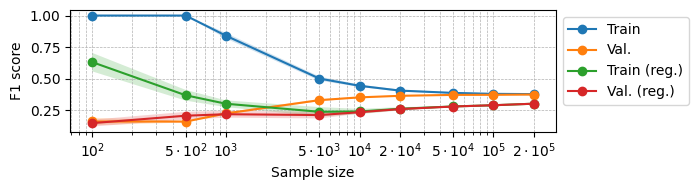

In [33]:
def mean_ci_normal(values):
    """Return mean and approximate CI half-width using normal distribution (z=1.96)."""
    arr = np.array(values)
    mean = np.mean(arr)
    std = np.std(arr, ddof=1)
    n = len(arr)
    z = 1.96
    h = z * std / np.sqrt(n)
    return mean, h


# Compute mean + CI per λ
results = {}
for _lambda in reversed(f1_train_scores.keys()):
    train_means, train_cis = [], []
    val_means, val_cis = [], []
    
    for n in num_samples:
        m, h = mean_ci_normal(f1_train_scores[_lambda][n])
        train_means.append(m)
        train_cis.append(h)
        m, h = mean_ci_normal(f1_val_scores[_lambda][n])
        val_means.append(m)
        val_cis.append(h)
    
    results[_lambda] = {
        "train_means": np.array(train_means),
        "train_cis": np.array(train_cis),
        "val_means": np.array(val_means),
        "val_cis": np.array(val_cis),
    }


# Plot
plt.figure(figsize=(7, 2))

for _lambda, res in results.items():  # reverse order for legend
    label_suffix = f" (reg.)" if _lambda != 0 else ""
    plt.plot(num_samples, res["train_means"], '-o', label='Train' + label_suffix)
    plt.plot(num_samples, res["val_means"], '-o', label='Val.' + label_suffix)

    plt.fill_between(num_samples,
                     res["train_means"] - res["train_cis"],
                     res["train_means"] + res["train_cis"], alpha=0.2)
    plt.fill_between(num_samples,
                     res["val_means"] - res["val_cis"],
                     res["val_means"] + res["val_cis"], alpha=0.2)

plt.xscale('log')
plt.xticks(
    num_samples,
    [f"$10^2$", f"$5\\cdot10^2$", f"$10^3$", f"$5\\cdot10^3$", f"$10^4$", f"$2\\cdot10^4$", f"$5\\cdot10^4$", f"$10^5$", f"$2\\cdot10^5$"],
    rotation=0,
    
)

plt.xlabel("Sample size")
plt.ylabel("F1 score")
# place legend right of plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.savefig("../results/ablations_sample_size.pdf")
plt.show()


In [33]:
print([np.mean(f1_train_scores[n]) for n in num_samples])
print([np.mean(f1_val_scores[n]) for n in num_samples])

[np.float64(1.0), np.float64(1.0), np.float64(0.8232344060583172), np.float64(0.49458696994923734), np.float64(0.4454650099453853), np.float64(0.4093231997868726), np.float64(0.38970234768763323), np.float64(0.38419402511056633), np.float64(0.38040122469487364)]
[np.float64(0.14735669477108274), np.float64(0.161575169121738), np.float64(0.2310033483701382), np.float64(0.33766188504431743), np.float64(0.35394544962734165), np.float64(0.3647492134927123), np.float64(0.37164993192003337), np.float64(0.3723999799480606), np.float64(0.37471610675895484)]


## L2 Regularization

kwarg_list([{"}])

## Decision Threshold Tuning

In [ ]:
kwarg_list = [{"tune_threshold": True}, {"tune_threshold": False}]
run_model_ablation(kwarg_list)

Running with args: {'tune_threshold': True}
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
Running with args: {'tune_threshold': False}
Starting fold 1/5 with 80000 samples
Starting fold 2/5 with 80000 samples
Starting fold 3/5 with 80000 samples
Starting fold 4/5 with 80000 samples
Starting fold 5/5 with 80000 samples
{'tune_threshold': True}
0.4181783307545988
{'tune_threshold': False}
-0.04556669703519711


# No weighting and no tuning

In [17]:
kwarg_list = [{"tune_threshold": True, "weighting": True}, {"tune_threshold": False, "weighting": False}]
run_model_ablation(kwarg_list, num_samples = int(4e4))

Running with args: {'tune_threshold': True, 'weighting': True}
Starting fold 1/5 with 32000 samples
Starting fold 2/5 with 32000 samples
Starting fold 3/5 with 32000 samples
Starting fold 4/5 with 32000 samples
Starting fold 5/5 with 32000 samples
Running with args: {'tune_threshold': False, 'weighting': False}
Starting fold 1/5 with 32000 samples
Starting fold 2/5 with 32000 samples
Starting fold 3/5 with 32000 samples
Starting fold 4/5 with 32000 samples
Starting fold 5/5 with 32000 samples
{'tune_threshold': True, 'weighting': True}
0.4056994158391004
{'tune_threshold': False, 'weighting': False}
-0.27907739332694803
